In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        return 'RNN with Fixed LR'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

# Collect aggregate metrics

In [37]:
root_dir = "../trained_models_copy/"
exp_dirs = [
    '03_td_discrete_uncorr/',
    '03_td_discrete_corr/'
    ]

dsets = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for exp_dir in exp_dirs:
    for dset in os.listdir(root_dir + exp_dir):
        dset_dir = f'{root_dir}{exp_dir}/{dset}/'

        for model in os.listdir(dset_dir):
            model_dir = dset_dir + model + '/'
            try:
                model_name = format_model_name(model)
            except:
                continue # Not a directory we care about
            for _iter in os.listdir(model_dir):
                iter_dir = model_dir + _iter + '/'
                for file in os.listdir(iter_dir):
                    if 'tfevents' not in file: continue
                    tfevents_file = iter_dir + '/' + file
                    event_acc = EventAccumulator(tfevents_file)
                    event_acc.Reload()
                    scalar_events = event_acc.Scalars('loss_train')
                    values = np.array([event.value for event in scalar_events])
                    steps = np.array([event.step for event in scalar_events])
                    central_diffs = values[1:] + values[:-1] - 2*values[:-1] 

                    dsets.append(dset)
                    models.append(model_name)
                    start_losses.append(values[0])
                    time_to_elbows.append(steps[np.argmax(central_diffs)])
                    final_losses.append(values[-1])
                    break

dsets = np.array(dsets)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

# Make barplots

In [58]:
df = pd.DataFrame({
    'Dataset': dsets,
    'Model': models,
    'Start Loss': np.clip(start_losses, 0., 0.3),
    'Time to Elbow': time_to_elbows,
    'Final Loss': final_losses
    })
hue_order = ['Linear', 'RNN with Fixed LR', 'MLP with Replay Buffer']

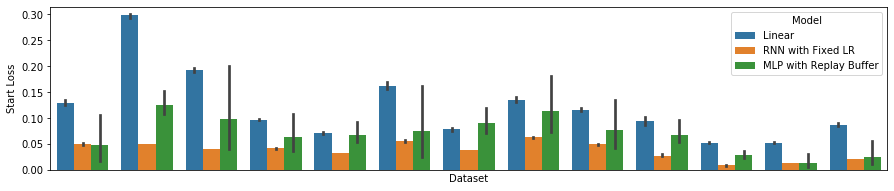

In [62]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Start Loss', hue='Model',
    ax=ax, data=df[df['Model'] != 'RNN with Dynamic LR'],
    hue_order=hue_order
    )
ax.set_xticks([])
plt.show()

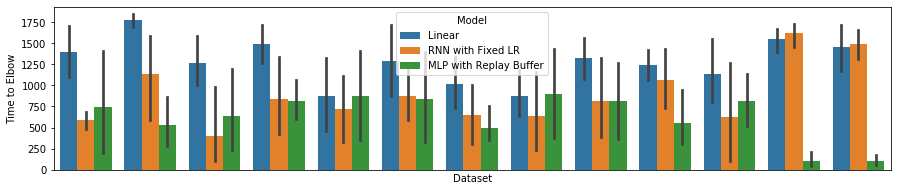

In [64]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Time to Elbow', hue='Model',
    ax=ax, data=df[df['Model'] != 'RNN with Dynamic LR'],
    hue_order=hue_order
    )
ax.set_xticks([])
plt.show()

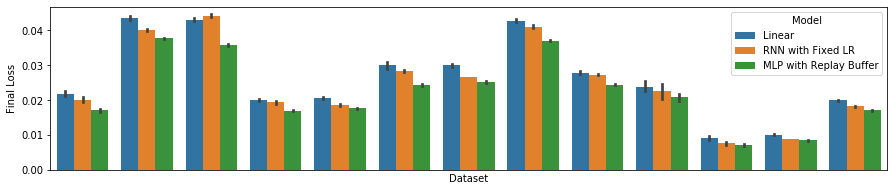

In [65]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(
    x='Dataset', y='Final Loss', hue='Model',
    ax=ax, data=df[df['Model'] != 'RNN with Dynamic LR'],
    hue_order=hue_order
    )
ax.set_xticks([])
plt.show()